In [ ]:
from google.colab import drive

# Google Drive'ı bağlama
drive.mount('/content/drive')

print("Google Drive bağlandı!")


Mounted at /content/drive
Google Drive bağlandı!


Eğitim setindeki resim sayısı: 19993
Doğrulama setindeki resim sayısı: 4999
Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


Epoch 1/10
Validation Loss: 0.1922
Validation Accuracy: 0.9388
Best model and hyperparameters updated and saved!

Epoch 2/10
Train Loss: 0.1233
Train Accuracy: 0.9600
Epoch Duration: 231.40 seconds
Validation Loss: 0.2136
Validation Accuracy: 0.9304

Epoch 3/10
Train Loss: 0.0731
Train Accuracy: 0.9762
Epoch Duration: 231.54 seconds
Validation Loss: 0.1529
Validation Accuracy: 0.9526
Best model and hyperparameters updated and saved!

Epoch 4/10
Train Loss: 0.0696
Train Accuracy: 0.9775
Epoch Duration: 231.91 seconds
Validation Loss: 0.1982
Validation Accuracy: 0.9418

Epoch 5/10
Train Loss: 0.0499
Train Accuracy: 0.9837
Epoch Duration: 231.67 seconds
Validation Loss: 0.1718
Validation Accuracy: 0.9490

Epoch 6/10
Train Loss: 0.0484
Train Accuracy: 0.9833
Epoch Duration: 231.39 seconds
Validation Loss: 0.1757
Validation Accuracy: 0.9498

Epoch 7/10
Train Loss: 0.0397
Train Accuracy: 0.9868
Epoch Duration: 231.18 seconds
Validation Loss: 0.1666
Validation Accuracy: 0.9548

Epoch 8/10
Tr

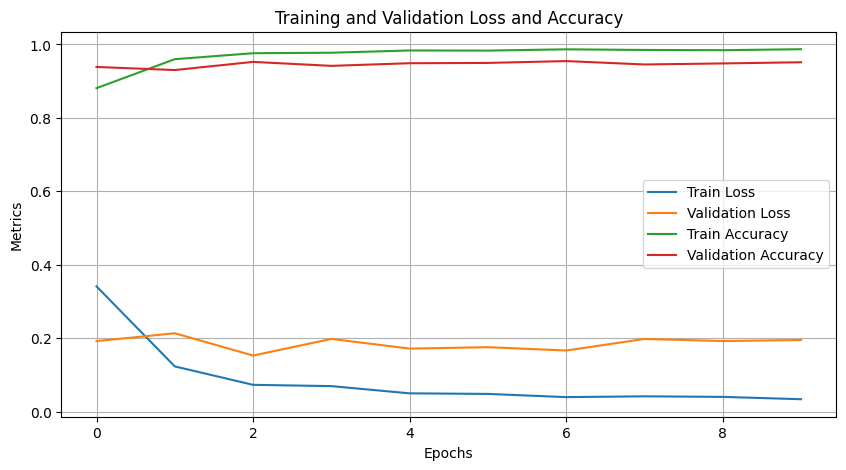

Total Training Time: 2560.41 seconds


<ipython-input-2-04e797c562e2>:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Total Inference Time: 24.57 seconds

Classification Report:
               precision    recall  f1-score   support

        ACNE       0.97      0.92      0.94      1000
      CHCPOX       0.93      0.92      0.93      1000
       NEVUS       0.98      0.99      0.98      1000
   PSORİASİS       0.93      0.94      0.94       999
    VİTİLİGO       0.96      0.99      0.97      1000

    accuracy                           0.95      4999
   macro avg       0.95      0.95      0.95      4999
weighted avg       0.95      0.95      0.95      4999

Class: ACNE, Sensitivity: 0.9240, Specificity: 0.9920
Class: CHCPOX, Sensitivity: 0.9190, Specificity: 0.9830
Class: NEVUS, Sensitivity: 0.9890, Specificity: 0.9940
Class: PSORİASİS, Sensitivity: 0.9389, Specificity: 0.9832
Class: VİTİLİGO, Sensitivity: 0.9920, Specificity: 0.9885


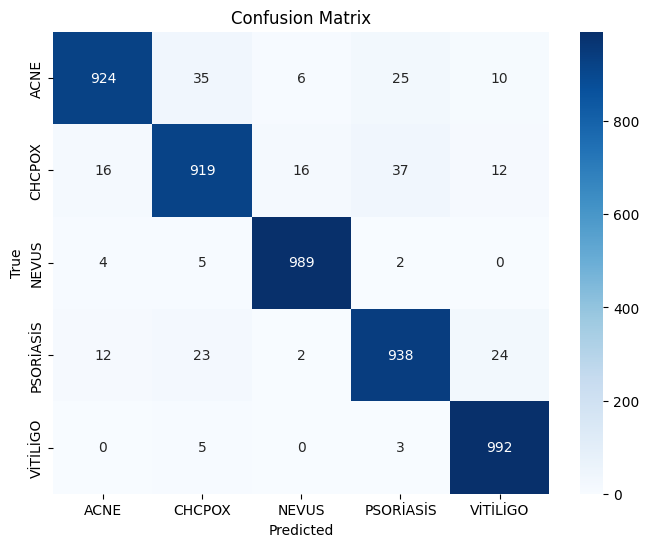

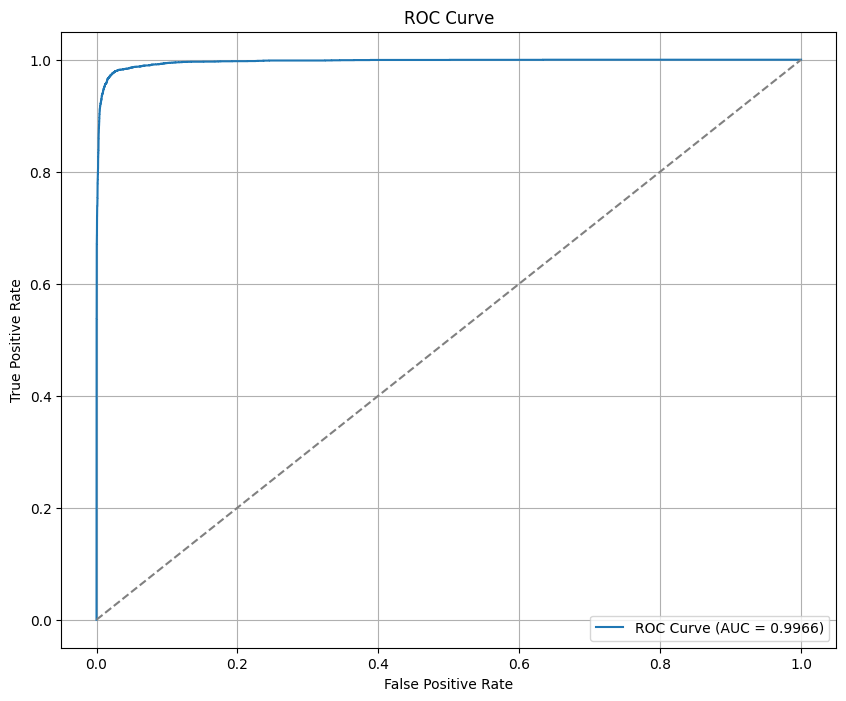

Precision: 0.9526
Recall: 0.9526
F1 Score: 0.9524
Balanced Accuracy: 0.9526


In [ ]:
import time
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Veri yolları
train_zip = '/content/drive/MyDrive/train.zip'
val_zip = '/content/drive/MyDrive/val.zip'
train_dir = '/content/train'
val_dir = '/content/val'

# ZIP dosyalarını çıkar
if os.path.exists(train_dir):
    os.system(f'rm -rf {train_dir}')
if os.path.exists(val_dir):
    os.system(f'rm -rf {val_dir}')

os.system(f'unzip -q {train_zip} -d /content')
os.system(f'unzip -q {val_zip} -d /content')

# Çıkarılan resim sayısını yazdır
valid_extensions = (".jpg", ".jpeg", ".png")
train_image_count = sum([len([file for file in files if file.lower().endswith(valid_extensions)]) for r, d, files in os.walk(train_dir)])
val_image_count = sum([len([file for file in files if file.lower().endswith(valid_extensions)]) for r, d, files in os.walk(val_dir)])
print(f"Eğitim setindeki resim sayısı: {train_image_count}")
print(f"Doğrulama setindeki resim sayısı: {val_image_count}")

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Veri seti yükleme
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# DeiT modeli oluşturma
def initialize_deit_model(num_classes):
    model = create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)
    model.to(device)
    return model

# Eğitim fonksiyonu
def train_deit_model(model, train_loader, val_loader, criterion, optimizer, epochs=15, model_path=None, hyperparams_path=None):
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    total_training_time = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        epoch_start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        total_training_time += epoch_duration

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Epoch Duration: {epoch_duration:.2f} seconds")

        val_loss, val_acc = validate_deit_model(model, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if model_path:
                torch.save(model.state_dict(), model_path)
            if hyperparams_path:
                best_hyperparams = {
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'epochs': epochs
                }
                torch.save(best_hyperparams, hyperparams_path)
            print("Best model and hyperparameters updated and saved!")

    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

    # Eğitim ve doğrulama kaybı grafikleri
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training and Validation Loss and Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    return train_loss_history, val_loss_history, best_val_loss

# Doğrulama fonksiyonu
def validate_deit_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    return val_loss, val_acc

# DeiT modeli eğitimi
model_path = '/content/drive/MyDrive/best_deit_model1.pth'
hyperparams_path = '/content/drive/MyDrive/best_deit_hyperparams1.pth'
num_classes = len(train_dataset.classes)

model = initialize_deit_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

start_training_time = time.time()
train_loss_history, val_loss_history, best_val_loss = train_deit_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10, model_path=model_path, hyperparams_path=hyperparams_path
)
end_training_time = time.time()
total_training_time = end_training_time - start_training_time

print(f"Total Training Time: {total_training_time:.2f} seconds")

# Test ve analiz fonksiyonları
def test_deit_model(model, val_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    return y_true, y_pred, y_probs

# En iyi modeli yükleme ve test etme
start_inference_time = time.time()
model.load_state_dict(torch.load(model_path))
y_true, y_pred, y_probs = test_deit_model(model, val_loader)
end_inference_time = time.time()
total_inference_time = end_inference_time - start_inference_time

print(f"Total Inference Time: {total_inference_time:.2f} seconds")

# Performans metrikleri
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y_true, y_pred)

# Sınıflandırma raporu
report = classification_report(y_true, y_pred, target_names=val_loader.dataset.classes)
print("\nClassification Report:\n", report)

# Duyarlılık ve Özgüllük hesaplama
cm = confusion_matrix(y_true, y_pred)
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = (cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + cm.diagonal()) / (cm.sum() - cm.sum(axis=1))

for idx, class_name in enumerate(val_loader.dataset.classes):
    print(f"Class: {class_name}, Sensitivity: {sensitivity[idx]:.4f}, Specificity: {specificity[idx]:.4f}")

# Karmaşıklık matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_loader.dataset.classes, yticklabels=val_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Eğrisi
y_true_one_hot = np.eye(num_classes)[y_true]
fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), np.array(y_probs).ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Sonuçları yazdır
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")



Eğitim setindeki resim sayısı: 19993
Doğrulama setindeki resim sayısı: 4999
Using device: cuda

Epoch 1/5
Train Loss: 0.3526
Epoch Duration: 241.88 seconds
Validation Loss: 0.1815
Best model updated and saved!

Epoch 2/5
Train Loss: 0.1300
Epoch Duration: 240.91 seconds
Validation Loss: 0.2038

Epoch 3/5
Train Loss: 0.0833
Epoch Duration: 240.36 seconds
Validation Loss: 0.1590
Best model updated and saved!

Epoch 4/5
Train Loss: 0.0732
Epoch Duration: 240.85 seconds
Validation Loss: 0.1843

Epoch 5/5
Train Loss: 0.0612
Epoch Duration: 240.43 seconds
Validation Loss: 0.1842

Total Training Time: 1735576797.04 seconds


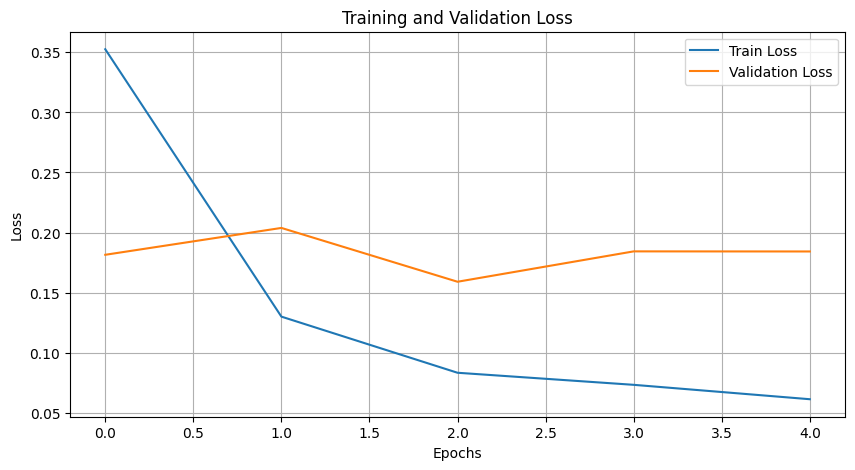